# DESAFÍO N° 2 - MODELADO

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV, ElasticNet, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, cross_val_score

from yellowbrick.regressor import AlphaSelection
from yellowbrick.regressor.alphas import manual_alphas

In [292]:
data = pd.read_csv("salida_desafio_1.csv")
data.sample(5)

,Unnamed: 0,tipo_prop,barrio,pais,lat,lon,precio_usd,piso,properati_url,ambientes,...,villa_crespo,hidromasaje,san_telmo,vista,sauna,losa_radiante,capital_federal,impecable,interwin,doble_circulacion
31444,31444,apartment,Villa Urquiza,Argentina,-34.566670,-58.483330,206856.0,0.0,http://www.properati.com.ar/1cgap_venta_depart...,3.0,...,0,0,0,0,0,0,0,0,0,0
19217,19217,apartment,Caballito,Argentina,-34.622640,-58.441040,159000.0,NaN,http://www.properati.com.ar/1ams2_venta_depart...,2.0,...,0,0,0,0,0,0,0,0,0,0
16088,16088,apartment,Caballito,Argentina,-34.608097,-58.449479,243000.0,2.0,http://www.properati.com.ar/1a40b_venta_depart...,3.0,...,0,0,0,0,0,0,0,0,0,0
3311,3311,apartment,Belgrano,Argentina,-34.563613,-58.458137,98800.0,NaN,http://www.properati.com.ar/16tbv_venta_depart...,1.0,...,0,0,0,0,0,1,0,0,0,0
30662,30662,PH,Villa Lugano,Argentina,-34.679070,-58.472630,145000.0,NaN,http://www.properati.com.ar/1cdg9_venta_ph_vil...,NaN,...,0,0,0,0,0,0,0,0,0,0


## Reducción de volumen de datos

Decidimos elegir como dataset de trabajo los barrios dentro de la Comuna 13: Belgrano, Nuñez y Colegiales

Esta decisión la tomamos ya que es una de las comunas con mayor desarrollo inmobiliario en la CABA. Vamos a trabajar con 4122 datos de tres barrios porteños.

In [293]:
data2 = data[(data.barrio == "Palermo") | (data.barrio == "Palermo Hollywood") | (data.barrio == "Palermo Soho") | (data.barrio == "Palermo Chico") | (data.barrio == "Palermo Viejo")]
data2.shape

(4083, 66)

## Preparación del DATASET

In [294]:
data2.sample(10)
data2.columns

data2.drop(['Unnamed: 0', 'pais', 'precio_usd', 'villa_urquiza', 'barrio_norte', 'villa_crespo', 'lujoso', 'san_telmo',
          'capital_federal', 'impecable', 'interwin', 'properati_url', 'properati_url_clean', 'geometry'], axis = 1, inplace = True)

In [295]:
data2['piso'] = data2.piso.apply(lambda x: np.NaN if x > 30 else x)
data2['ambientes'] = data2.ambientes.apply(lambda x: np.NaN if x > 8 else x)
data2['sup_total'] = data2.sup_total.apply(lambda x: np.NaN if x == 0 else x)

In [296]:
a = data2[data2.tipo_prop == "apartment"].piso.fillna(int(data2.piso.mode()))
b = data2[data2.tipo_prop != "apartment"].piso.fillna(0)

piso = a.append(b)

data2['piso'] = data2.piso.fillna(piso)

data2.ambientes.fillna(int(data2.ambientes.mode()), inplace = True)

data2.isnull().sum()

data2 = data2[data2.sup_total.notnull()]

data = data2[data2.precio_x_m2_usd.notnull()]

## Modelado

#### Preparación de dummies y categoricas

In [297]:
a = pd.get_dummies(data[['tipo_prop']])
a.drop(['tipo_prop_apartment'], inplace= True, axis = 1)

data = pd.merge(data, a, left_index= True, right_index= True)

In [298]:
a = pd.get_dummies(data[['barrio']])
a.drop(['barrio_Palermo'], inplace= True, axis = 1)

data = pd.merge(data, a, left_index= True, right_index= True)

In [299]:
data = data[data.precio_x_m2_usd < 12000]
data = data[data.precio_x_m2_usd > 800]

## Feature Engineering

In [300]:
a = data.sup_total - data.sup_cubierta
data['sup_libre'] = a.apply(lambda x: 0 if x <= 0 else x)
data['por_sup_libre'] = data.sup_libre / data.sup_total
data['por_sup_cubierta'] = data.sup_cubierta/data.sup_total

data['ambientes'] = data.ambientes.apply(lambda x: 1 if x == 0 else x)
data['tamaño_ambiente'] = data['sup_cubierta'] / data['ambientes']


data['sup_cubierta_2'] = np.square(data.sup_cubierta)
data['sup_total_2'] = np.square(data.sup_total)
data['sup_libre_2'] = np.square(data.sup_libre)


data['comisarias_2'] = np.square(data.comisarias)
data['espacios_verdes_2'] = np.square(data.espacios_verdes)
data['hospitales_2'] = np.square(data.Hospitales)
data['educacion_2'] = np.square(data.Educacion)


data['zona_verde_mucho'] = data.espacios_verdes_cant.apply(lambda x: 1 if x > 10 else 0)
data['zona_verde_poco'] = data.espacios_verdes_cant.apply(lambda x: 1 if x < 4 else 0)


a = data.parrilla + data.piscina + data['sum'] + data.gimnasio + data.sauna
data['amenity'] = a.apply(lambda x: 1 if x > 0 else 0)

data['amenity_otro'] = data.parrilla * data.piscina + data['sum'] + data.gimnasio


data['ferrocarril_cat'] = data.Ferrocarril.apply(lambda x: 1 if x < 700 else 0)


data['hospitales_cat'] = data.Hospitales.apply(lambda x: 1 if x < 1000 else 0)
data['educacion_cat'] = data.Educacion.apply(lambda x: 1 if x < 1000 else 0)
data['seguridad_cat'] = data.comisarias.apply(lambda x: 1 if x < 1000 else 0)

data['ss'] = data.hospitales_cat * data.seguridad_cat
data['se'] = data.hospitales_cat * data.educacion_cat
data['es'] = data.educacion_cat * data.seguridad_cat
data['sse'] = data.hospitales_cat * data.seguridad_cat * data.educacion_cat

data['patio_parrilla'] = data.parrilla * (data.patio + data.jardin)
data['patio_parrilla'] = data.patio_parrilla.apply(lambda x: 1 if x >= 1 else x)
data['patio_parrilla_piscina'] = data.parrilla * data.piscina * (data.patio + data.jardin)
data['patio_parrilla_piscina'] = data.patio_parrilla_piscina.apply(lambda x: 1 if x >= 1 else x)


a = data.jardin + data.patio
data['patios'] = a.apply(lambda x: 1 if x > 0 else 0)
data['libre_abierto'] = data.sup_libre * data.patios


a = data.jardin + data.patio + data.terraza + data.balcon
data['espacio_abierto'] = a.apply(lambda x: 1 if x > 0 else 0)


data['piso_luminoso'] = data.piso.apply(lambda x: 1 if x > 5 else 0)


data['zona_comercial'] = data.comercios_cerca.apply(lambda x: 1 if x > 150 else 0)


data['subtes_cat'] = data.subtes.apply(lambda x: 'ninguno' if x == 0 else ('uno' if x == 1 else 'dos_o_mas'))
data['bicis_cat'] = data.bicis.apply(lambda x: 'ninguna' if x == 0 else 'alguna')


a = pd.get_dummies(data[['subtes_cat', 'bicis_cat']])
a.drop(['subtes_cat_ninguno', 'bicis_cat_ninguna'], inplace= True, axis = 1)
data = pd.merge(data, a, left_index= True, right_index= True)
data.drop(['subtes_cat', 'bicis_cat'], axis = 1, inplace= True)

In [301]:
data.drop(['subte_linea_a', 'subte_linea_c', 'subte_linea_e'], axis = 1, inplace=True)

In [302]:
data[(data.precio_x_m2_usd > 8000) & (data.tipo_prop_store == 0)]

,tipo_prop,barrio,lat,lon,piso,ambientes,sup_total,sup_cubierta,precio_x_m2_usd,subtes,...,patio_parrilla,patio_parrilla_piscina,patios,libre_abierto,espacio_abierto,piso_luminoso,zona_comercial,subtes_cat_dos_o_mas,subtes_cat_uno,bicis_cat_alguna
1021,apartment,Palermo,-34.575551,-58.422184,2.0,4.0,210.000000,210.000000,8333.333333,0,...,0,0,0,0.000000,0,0,0,0,0,1
8022,house,Palermo,-34.578327,-58.400505,2.0,2.0,300.000000,380.000000,9966.666667,0,...,0,0,0,0.000000,0,0,0,0,0,1
8418,apartment,Palermo Chico,-34.585220,-58.426652,2.0,4.0,147.000000,147.000000,9523.809524,0,...,0,0,0,0.000000,1,0,0,0,0,1
8419,apartment,Palermo,-34.579549,-58.407713,2.0,4.0,145.000000,145.000000,9655.172414,0,...,0,0,0,0.000000,0,0,1,0,0,1
9851,PH,Palermo,-34.592049,-58.416400,0.0,5.0,25.200828,20.000000,10634.571067,0,...,0,0,0,0.000000,0,0,0,0,0,1
10159,apartment,Palermo Chico,-34.575761,-58.421913,2.0,3.0,138.465905,128.000000,8124.743751,0,...,1,1,1,10.465905,1,0,0,0,0,1
10495,apartment,Palermo,-34.577818,-58.406038,2.0,2.0,254.000000,220.000000,9803.149606,0,...,0,0,0,0.000000,0,0,0,0,0,1
12935,apartment,Palermo,-34.574987,-58.420583,2.0,5.0,377.000000,377.000000,10875.331565,0,...,0,0,0,0.000000,0,0,0,0,0,1
14100,apartment,Palermo,-34.574987,-58.420583,2.0,5.0,400.000000,400.000000,11000.000000,0,...,0,0,0,0.000000,0,0,0,0,0,1
15479,apartment,Palermo,-34.581787,-58.422483,2.0,4.0,35.000000,35.000000,8068.237714,1,...,0,0,0,0.000000,0,0,1,0,1,1


## CLUSTERING

Una posibilidad que podría mejorar el rendimiento del algoritmo es generar clusters dentro del barrio elegido según el tipo de propiedad y usando como variables el rpecio_x_m2 y la localización geográfia (lat/lon). Eso podría ayudarnos a ubicar patrones geográficos en los precios

In [303]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

### Apartments

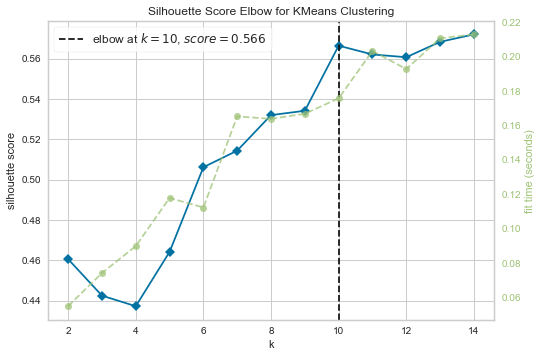

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [304]:
data_clus = data

data_clus = data_clus[(data_clus.tipo_prop == "apartment")]
data_clus = data_clus[['lat', 'lon','tipo_prop']]

# data_clus = data_clus[data_clus.precio_x_m2_usd.notnull()]

# escalador = StandardScaler()
# X = escalador.fit_transform(data_clus.drop('tipo_prop', axis = 1))

X = data_clus.drop('tipo_prop', axis = 1)

km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k = (2,15), metric = 'silhouette')

visualizer.fit(X)
visualizer.show()

In [305]:
km_model = KMeans(n_clusters=4)

km_model.fit(X)

clusters = pd.Series(km_model.predict(X), index = data_clus.index, name = 'clusters_apartment')
data_clus_apartment = data_clus.join(clusters)

### Houses

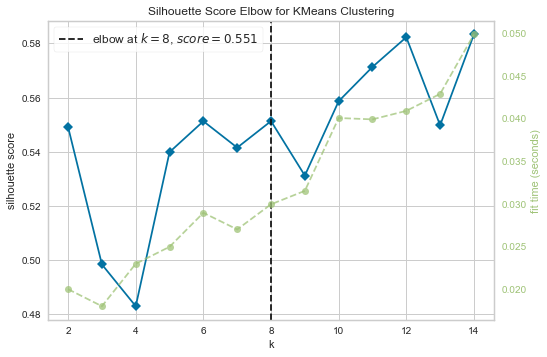

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [306]:
data_clus = data

data_clus = data_clus[(data_clus.tipo_prop == "house")]
data_clus = data_clus[['lat', 'lon','tipo_prop']]

# data_clus = data_clus[data_clus.precio_x_m2_usd.notnull()]

# escalador = StandardScaler()
# X = escalador.fit_transform(data_clus.drop('tipo_prop', axis = 1))

X = data_clus.drop('tipo_prop', axis = 1)

km_model = KMeans()
visualizer = KElbowVisualizer(km_model, k = (2,15), metric = 'silhouette')

visualizer.fit(X)
visualizer.show()

In [307]:
km_model = KMeans(n_clusters=4)

km_model.fit(X)

clusters = pd.Series(km_model.predict(X), index = data_clus.index, name = 'clusters_house')
data_clus_house = data_clus.join(clusters)

In [308]:
data = data.join(data_clus_apartment.clusters_apartment)
data = data.join(data_clus_house.clusters_house)

In [309]:
dummy_apartment = pd.get_dummies(data.clusters_apartment, dummy_na=True)
dummy_apartment.columns = ['ap_0','ap_1', 'ap_2', 'ap_3', 'Vacio']
dummy_apartment.drop(['Vacio'], inplace=True, axis = 1)

dummy_house = pd.get_dummies(data.clusters_house, dummy_na=True)
dummy_house.columns = ['h_0', 'h_1', 'h_2', 'h_3', 'Vacio']
dummy_house.drop(['Vacio'], inplace=True, axis = 1)

data = data.join(dummy_apartment)
data = data.join(dummy_house)

## Cercanía Avenidas

In [310]:
import geopandas as geo

In [311]:
calles = geo.read_file("callejero-ba.txt").to_crs("EPSG:3395")

In [312]:
dptos = geo.GeoDataFrame(data, geometry=geo.points_from_xy(data.lon, data.lat))
dptos = dptos.set_crs(epsg=4326)
dptos = dptos.to_crs("EPSG:3395")

In [313]:
calles_listado = ['DEL LIBERTADOR AV.', 'SANTA FE AV.', 'FIGUEROA ALCORTA, PRES. AV.', 'SARMIENTO AV.', 'CAMPOS, LUIS M. AV.', 
                  'DORREGO AV.', 'OBLIGADO RAFAEL, Av.Costanera', 'LAS HERAS GENERAL AV.', 'CERVIÑO AV.', 'SCALABRINI ORTIZ, RAUL AV.', 
                  'CABILDO AV.', 'JUSTO, JUAN B. AV.', 'ORTIZ DE OCAMPO AV.', 'VEGA, NICETO, Cnel. AV.', 'JUSTO, JUAN B. AV.',
                 'CORDOBA AV.']

mascara = [x in calles_listado for x in calles.nomoficial]

calle = calles[mascara]

a = pd.DataFrame()


for i in dptos.geometry:
    distancias = calles.geometry.distance(i)
    distancias.name = "distancias"

    distancia_dpto = pd.merge(calle.nomoficial, distancias, right_index= True, left_index= True)
    
    c = list(distancia_dpto[distancia_dpto.distancias < 100].nomoficial.unique())
    
    if len(c) > 0:
        b = pd.DataFrame(np.ones_like(c).reshape(-1,len(c)), columns = c)
        a = pd.concat([a,b])
    else:
        a = a.append(pd.Series(), ignore_index=True)

a.index = dptos.index

In [314]:
a = a.fillna(0).astype(int)
data = data.join(a)

In [315]:
data['scalabrini_stafe'] = data['SCALABRINI ORTIZ, RAUL AV.'] * data['SANTA FE AV.']
data['scalabrini_cordoba'] = data['SCALABRINI ORTIZ, RAUL AV.'] * data['CORDOBA AV.']
data['scalabrini_lh'] = data['SCALABRINI ORTIZ, RAUL AV.'] * data['LAS HERAS GENERAL AV.']
data['lh_stafe'] = data['SANTA FE AV.'] * data['LAS HERAS GENERAL AV.']
data['liberta_lmcampos'] = data['DEL LIBERTADOR AV.'] * data['CAMPOS, LUIS M. AV.']
data['jbj_stafe'] = data['JUSTO, JUAN B. AV.'] * data['SANTA FE AV.']
data['jbj_cordoba'] = data['JUSTO, JUAN B. AV.'] * data['CORDOBA AV.']
data['jbj_nv'] = data['JUSTO, JUAN B. AV.'] * data['VEGA, NICETO, Cnel. AV.']

In [320]:
data.drop(['barrio', 'tipo_prop', 'lat', 'lon', 'clusters_house', 'clusters_apartment', 'geometry'], axis = 1, inplace= True)

### Train_test_split
Separamos el dataset en un segmento de entrenameinto y otro de testeo

In [321]:
X = data.drop('precio_x_m2_usd', axis = 1)
y = data.precio_x_m2_usd

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 555)


Xs = data.drop('precio_x_m2_usd', axis = 1)
ys = data.precio_x_m2_usd

std = StandardScaler()

X_std = Xs[['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis', 
           'comisarias', 'sup_libre', 'por_sup_libre', 'por_sup_cubierta',
       'tamaño_ambiente', 'sup_cubierta_2', 'sup_total_2', 'sup_libre_2',
       'comisarias_2', 'libre_abierto', 'Hospitales', 'Educacion',
       'Ferrocarril', 'espacios_verdes', 'Metrobus', 'Comercio', 'espacios_verdes_2', 'hospitales_2', 'educacion_2',
           'comercios_cerca', 'espacios_verdes_cant']]

X_std = std.fit_transform(X_std)

Xs[['piso', 'ambientes', 'sup_total', 'sup_cubierta', 'subtes', 'bicis', 'comisarias', 'sup_libre', 'por_sup_libre', 'por_sup_cubierta','tamaño_ambiente', 'sup_cubierta_2', 'sup_total_2', 'sup_libre_2','comisarias_2', 'libre_abierto', 'Hospitales', 'Educacion', 'Ferrocarril', 'espacios_verdes', 'Metrobus', 'Comercio', 'espacios_verdes_2', 'hospitales_2', 'educacion_2', 'comercios_cerca', 'espacios_verdes_cant']] = X_std

Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, shuffle = True)

In [322]:
print(X_train.shape)
print(X_test.shape)

(2607, 113)
(869, 113)


### Regresión Lineal Multiple

In [323]:
model_lrm = LinearRegression()

model_lrm.fit(X_train, y_train)
print(model_lrm.score)

y_predict = model_lrm.predict(X_test)

print("El score obtenido en el dataset de training fue de:", r2_score(y_train, model_lrm.predict(X_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(y_test, y_predict))

<bound method RegressorMixin.score of LinearRegression()>
El score obtenido en el dataset de training fue de: 0.35233016656160165
El score obtenido en el dataset de testing fue de: 0.3019943059118869


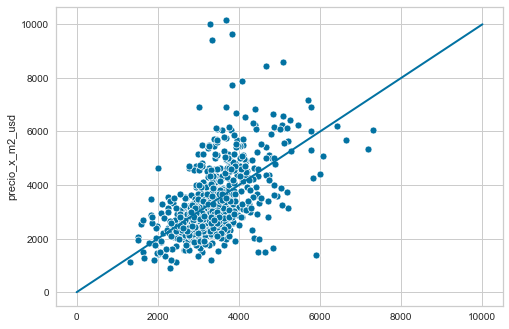

In [324]:
sns.scatterplot(y = y_test, x = y_predict)
plt.plot([0, 10000], [0, 10000], linewidth=2)
plt.show()

## WARNINGS

Importamos un metodo para evitar los print de warnings en casos donde la solución no converge

In [325]:
import warnings
warnings.filterwarnings('ignore')

## LASSO

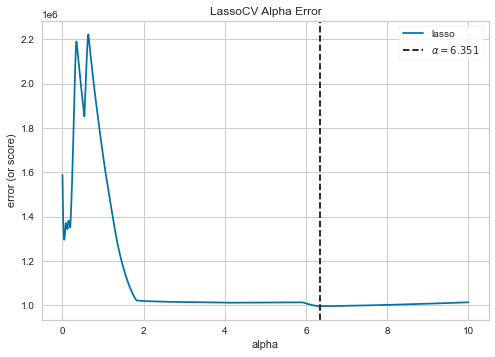

<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [327]:
model_lasso = LassoCV(cv = 3, alphas = np.linspace(0,10,5000))
visualizer = AlphaSelection(model_lasso)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

In [328]:
model_lasso = LassoCV(cv = 3, alphas = np.linspace(0,10,5000))

model_lasso.fit(Xs_train, ys_train)
y_predict = model_lasso.predict(Xs_test)

print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_lasso.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))
print()
coeficientes = list(model_lasso.coef_)
nombre = list(Xs.columns)

coef = pd.DataFrame(coeficientes, index = nombre)
coef

El score obtenido en el dataset de training fue de: 0.3225034193865991
El score obtenido en el dataset de testing fue de: 0.22041414468404996



,0
piso,-0.000000
ambientes,-27.205427
sup_total,0.000000
sup_cubierta,201.692448
subtes,-76.482184
...,...
lh_stafe,0.000000
liberta_lmcampos,0.000000
jbj_stafe,-0.000000
jbj_cordoba,-0.000000


In [329]:
coef.columns = ['a']
np.abs(coef).sort_values(ascending = False, by = 'a')[:40]

,a
CERVIÑO AV.,474.644849
vestidor,434.774792
tipo_prop_store,419.927050
gimnasio,341.138889
vista,333.518562
SANTA FE AV.,301.275145
sup_libre,257.039427
barrio_Palermo Chico,224.957021
sup_cubierta,201.692448
CORDOBA AV.,199.915511


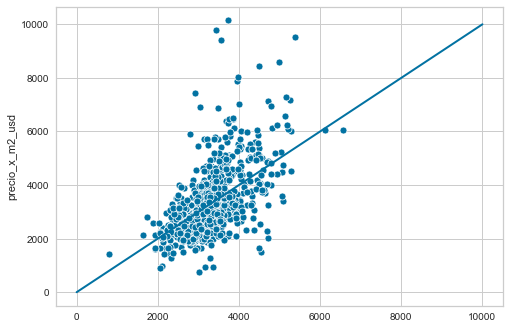

In [221]:
sns.scatterplot(y = ys_test, x = y_predict)
plt.plot([0, 10000], [0, 10000], linewidth=2)
plt.show()

## RIDGE

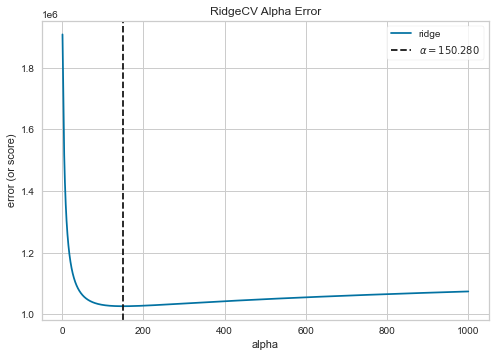

<AxesSubplot:title={'center':'RidgeCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [332]:
model_ridge = RidgeCV(alphas = np.linspace(1,200,5000))
visualizer = AlphaSelection(model_ridge)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

In [334]:
model_ridge = RidgeCV(cv = 3, alphas = np.linspace(100,200,500))


model_ridge.fit(Xs_train, ys_train)
y_predict = model_ridge.predict(Xs_test)

print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_ridge.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))
print()
coeficientes = list(model_ridge.coef_)
nombre = list(Xs.columns)

coef = pd.DataFrame(coeficientes, index = nombre)
coef

El score obtenido en el dataset de training fue de: 0.3269302185885825
El score obtenido en el dataset de testing fue de: 0.2299060106316999



,0
piso,-1.353538
ambientes,-27.281206
sup_total,56.514671
sup_cubierta,168.787665
subtes,-73.819745
...,...
lh_stafe,0.000000
liberta_lmcampos,0.000000
jbj_stafe,-25.184110
jbj_cordoba,-41.134128


## ELASTICNET

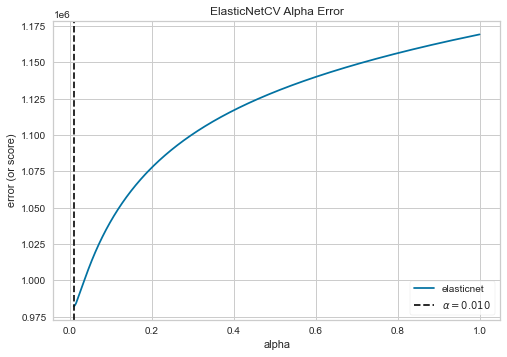

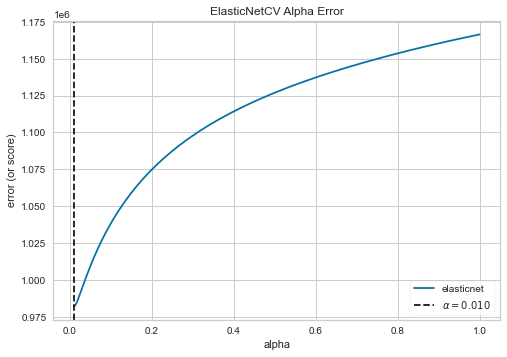

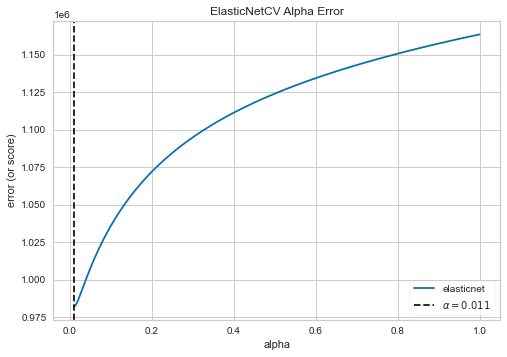

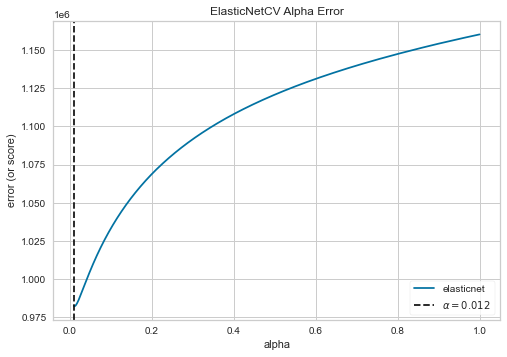

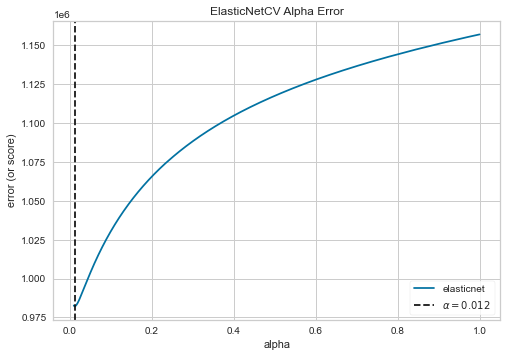

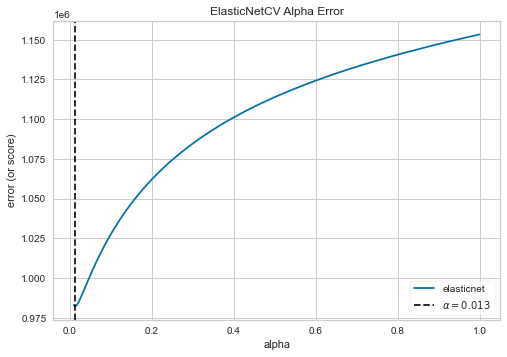

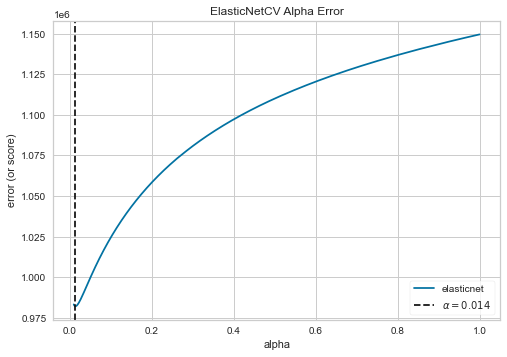

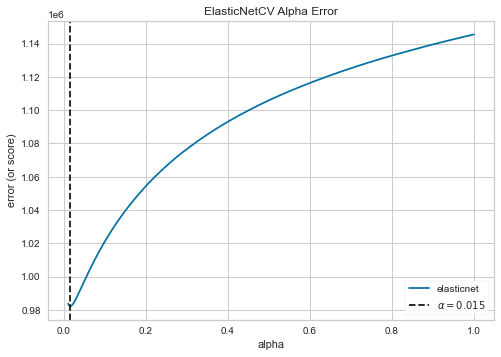

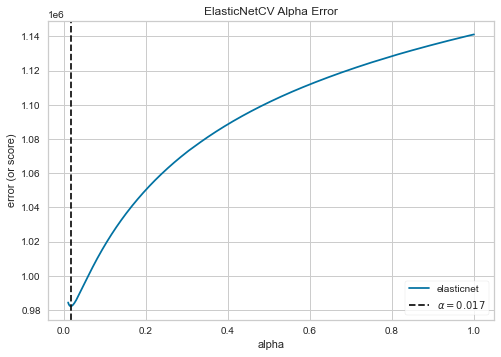

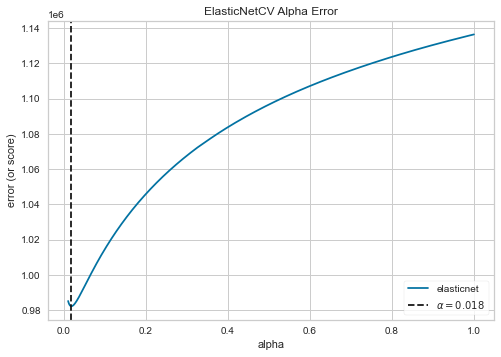

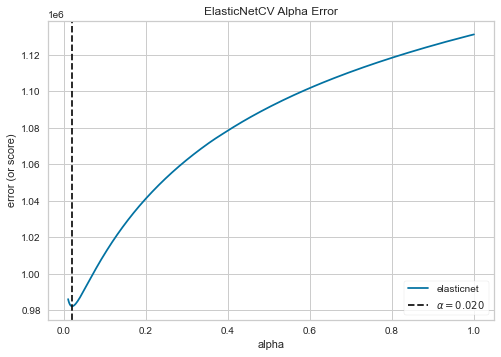

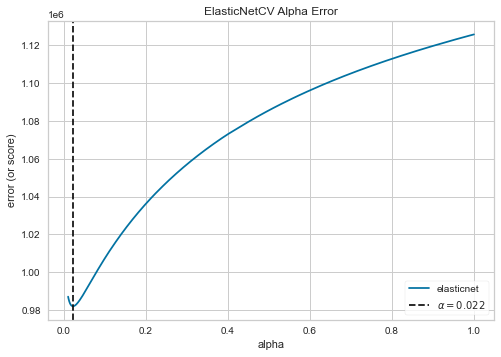

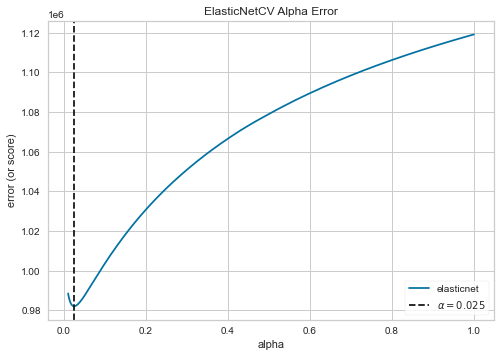

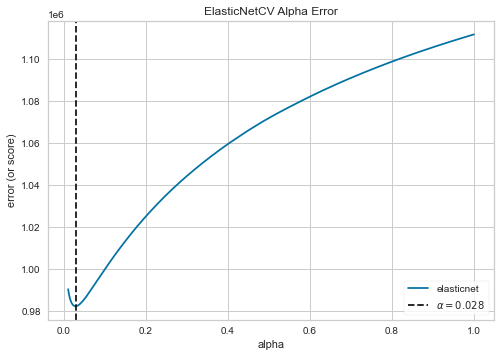

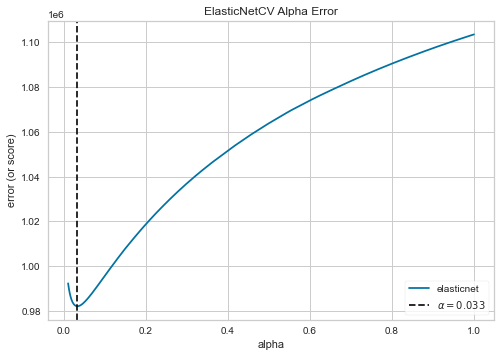

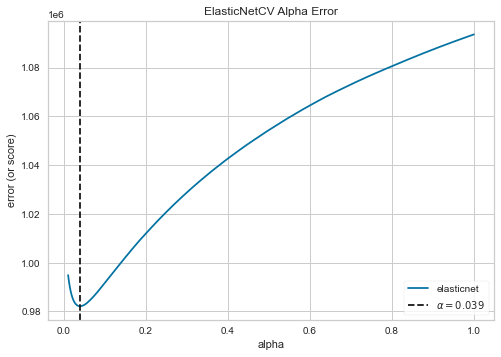

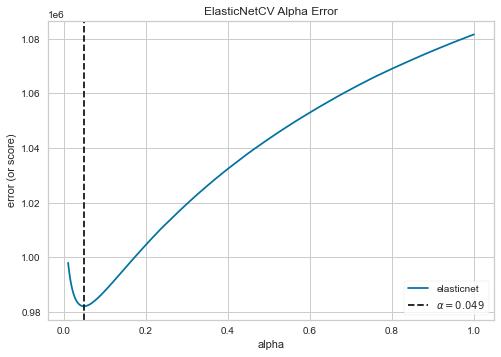

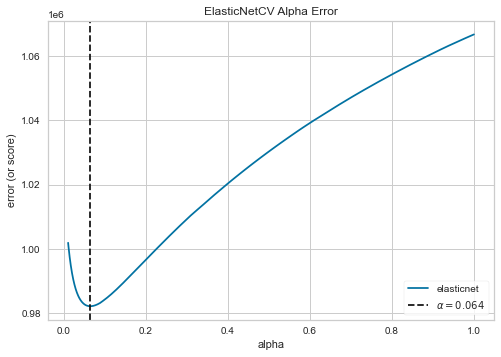

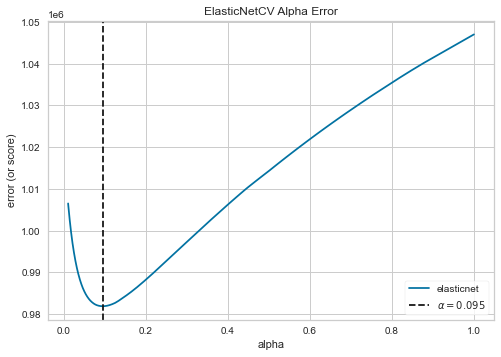

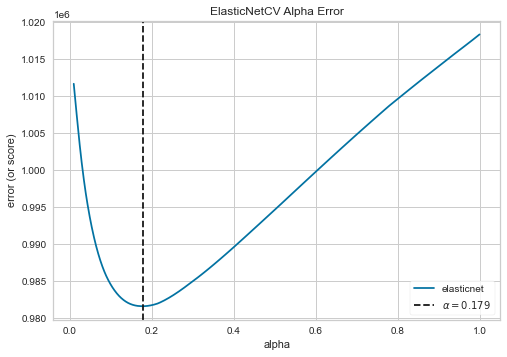

[0.23421178836722678,
 0.23414321389787096,
 0.2341520366174168,
 0.23422084120333453,
 0.23415853830335664,
 0.23414513658630098,
 0.23416521099289034,
 0.23420130546785056,
 0.2341721390919107,
 0.23419739866408884,
 0.23419027315602003,
 0.23418333541713532,
 0.234143977925378,
 0.23415413725677026,
 0.2341319325893061,
 0.23410476058024998,
 0.2340789810185021,
 0.23403924018807354,
 0.2339496454655593,
 0.2337285760702147]

In [199]:
metrica_r2 = []
for x in np.linspace(0.05,0.95,20):
    model_eln = ElasticNetCV(cv = 3, l1_ratio=x, alphas = np.linspace(0.01,1,5000))
    visualizer = AlphaSelection(model_eln)
    visualizer.fit(Xs_train, ys_train)
    visualizer.show()

    
    model_eln = ElasticNetCV(cv = 3, l1_ratio= visualizer.l1_ratio_, alphas = visualizer.alphas)

    model_eln.fit(Xs_train, ys_train)
    y_predict = model_eln.predict(Xs_test)
    
    metrica_r2.append(r2_score(ys_test, y_predict))

metrica_r2

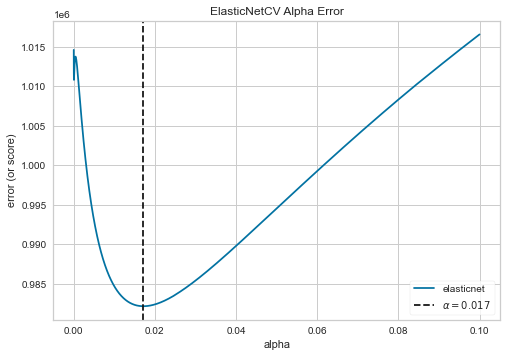

El score obtenido en el dataset de training fue de: 0.3363484318576925
El score obtenido en el dataset de testing fue de: 0.23417856905882783


In [200]:
model_eln = ElasticNetCV(cv = 3, l1_ratio=0.45, alphas = np.linspace(0,0.1,5000))
visualizer = AlphaSelection(model_eln)
visualizer.fit(Xs_train, ys_train)
visualizer.show()

model_eln = ElasticNetCV(cv = 3, l1_ratio= visualizer.l1_ratio_, alphas = visualizer.alphas, tol = 0.01)

model_eln.fit(Xs_train, ys_train)
y_predict = model_eln.predict(Xs_test)
    
print("El score obtenido en el dataset de training fue de:", r2_score(ys_train, model_eln.predict(Xs_train)))
print("El score obtenido en el dataset de testing fue de:", r2_score(ys_test, y_predict))